In [1]:
import sys
sys.path.append('..')

import tomodpdt

import numpy as np
import time
import matplotlib.pyplot as plt

import deeplay as dl

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEV)

Using device: cuda


In [3]:
data = np.load('D:/NewDataMonica/data_full_09_10_2024_HEK_03_04_us4.npz', allow_pickle=True)

In [4]:
data.keys()

KeysView(NpzFile 'D:/NewDataMonica/data_full_09_10_2024_HEK_03_04_us4.npz' with keys: E, q, t, n)

In [5]:
E = data['E'][np.random.randint(0, 1000, 9)]
E.shape

(9, 174, 200)

In [6]:
volume = data['n']

In [7]:
volume.shape

(150, 174, 200)

In [8]:
# Make volume to a cube
def make_cube(volume):
    # Get the shape of the volume
    z, y, x = volume.shape

    # Find the minimum dimension
    min_dim = min(z, y, x)

    # Calculate the center of the volume
    center_z = z // 2
    center_y = y // 2
    center_x = x // 2

    # Calculate the half size of the cube
    half_size = min_dim // 2

    # Calculate the start and end indices for each dimension
    start_z = center_z - half_size
    end_z = center_z + half_size
    start_y = center_y - half_size
    end_y = center_y + half_size
    start_x = center_x - half_size
    end_x = center_x + half_size

    # Extract the cube from the volume
    cube = volume[start_z:end_z, start_y:end_y, start_x:end_x]

    return cube

def resize_volume(volume, new_size):
    # Get the original shape of the volume
    z, y, x = volume.shape

    # Calculate the scaling factors for each dimension
    scale_z = new_size / z
    scale_y = new_size / y
    scale_x = new_size / x
    # Create a new volume with the desired shape
    new_volume = np.zeros((new_size, new_size, new_size), dtype=volume.dtype)
    # Iterate over each voxel in the new volume
    for i in range(new_size):
        for j in range(new_size):
            for k in range(new_size):
                # Calculate the corresponding voxel in the original volume
                orig_i = int(i / scale_z)
                orig_j = int(j / scale_y)
                orig_k = int(k / scale_x)
                # Assign the value from the original volume to the new volume
                new_volume[i, j, k] = volume[orig_i, orig_j, orig_k]
    return new_volume

In [9]:
volume = make_cube(volume)

In [10]:
volume.shape

(150, 150, 150)

In [11]:
N = 128

In [12]:
volume = resize_volume(volume, N)

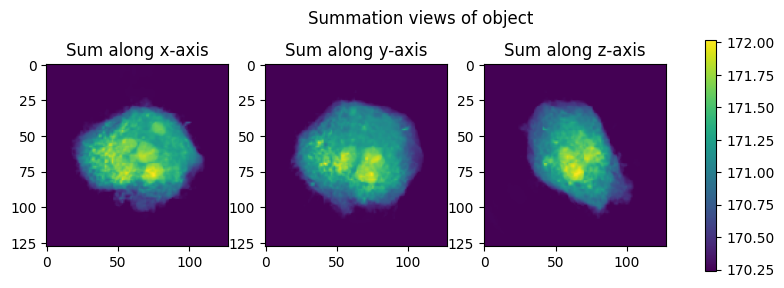

In [13]:
tomodpdt.plotting.plot_sum_object(volume)

In [14]:
print(volume.max(), volume.min() )


1.5439355 1.33


In [15]:
E = E[...,:, :174]
E = np.abs(E)

In [16]:
# Downsample to size

def downsample_image_2d(image, target_size):
    """
    Downsample a 2D image to the target size using nearest neighbor interpolation.
    """
    # Get the original shape of the image
    original_size = image.shape

    # Calculate the scaling factors for each dimension
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    # Create a new image with the desired shape
    new_image = np.zeros(target_size, dtype=image.dtype)

    # Iterate over each pixel in the new image
    for i in range(target_size[0]):
        for j in range(target_size[1]):
            # Calculate the corresponding pixel in the original image
            orig_i = int(i / scale_x)
            orig_j = int(j / scale_y)
            # Assign the value from the original image to the new image
            new_image[i, j] = image[orig_i, orig_j]

    return new_image

In [17]:
E = np.stack([downsample_image_2d(e, (N, N)) for e in E])

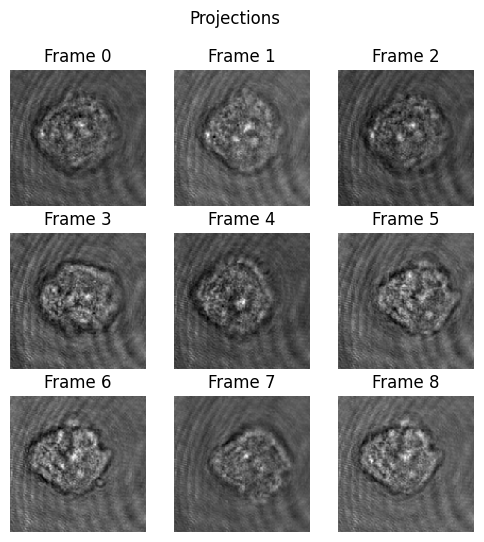

In [18]:
tomodpdt.plotting.plot_grid33_frames(np.expand_dims(np.abs(E), axis=1), title="Projections", save_folder='test_optics/', save_name=f'original.png')

In [19]:
from tomodpdt.imaging_modality_torch import setup_optics, imaging_model

# Create folder to store results in
import os
os.makedirs('test_optics', exist_ok=True)

c:\Users\Fredrik\Documents\GitHub\TomoDpDt\Notebooks\..\tomodpdt\image_modalities_dt.py:744: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pupils = [torch.tensor(pupil, dtype=torch.complex64).to(volume.device) for pupil in pupils]


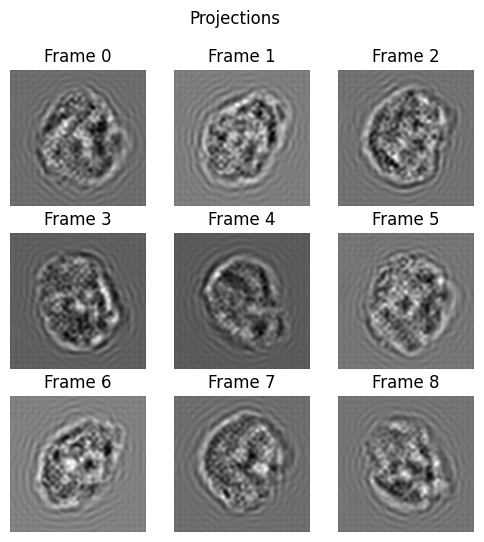

In [20]:
 # Setup the optics
optics_setttings = setup_optics(
        nsize=N, 
        padding_xy=128, 
        microscopy_regime='Brightfield', 
        NA=1.15, 
        wavelength=620e-9, 
        resolution=238e-9, 
        magnification=1, 
        return_field=False)

# Generate the imaging model
brightfield_model = imaging_model(optics_setup=optics_setttings)

_, _, projections, _ = tomodpdt.simulate.create_data(
volume=volume, # The volume we want to reconstruct
image_modality=brightfield_model, # We use the sum model
rotation_case='1ax', # We rotate the object around 1 main axis
samples=20, # Number of projections
duration=2 # Duration is the number of full revolutions
)

# Save the projections
tomodpdt.plotting.plot_grid33_frames(projections, title="Projections", save_folder='test_optics/', save_name=f'paper_settings.png')

In [21]:
if False:
    #Test different  NA, wavelength, resolution
    NA = np.linspace(0.7, 1.3, 10)
    wavelength = np.linspace(400e-9, 700e-9, 20)
    resolution = np.linspace(50e-9, 200e-9, 10)
    # Create a meshgrid of the parameters
    NA_grid, wavelength_grid, resolution_grid = np.meshgrid(NA, wavelength, resolution)
    # Flatten the grids to create a list of parameter combinations
    param_combinations = np.array([NA_grid.flatten(), wavelength_grid.flatten(), resolution_grid.flatten()]).T

    for i in range(param_combinations.shape[0]):
        NA = param_combinations[i, 0]
        wavelength = param_combinations[i, 1]
        resolution = param_combinations[i, 2]

        # Print the parameter combination
        print(f"NA: {NA}, Wavelength: {wavelength}, Resolution: {resolution}")
        try:
            # Setup the optics
            optics_setttings = setup_optics(
                    nsize=N, 
                    padding_xy=128, 
                    microscopy_regime='Brightfield', 
                    NA=NA, 
                    wavelength=wavelength, 
                    resolution=resolution, 
                    magnification=1, 
                    return_field=False)

            # Generate the imaging model
            brightfield_model = imaging_model(optics_setup=optics_setttings)

            _, _, projections, _ = tomodpdt.simulate.create_data(
            volume=volume, # The volume we want to reconstruct
            image_modality=brightfield_model, # We use the sum model
            rotation_case='1ax', # We rotate the object around 1 main axis
            samples=20, # Number of projections
            duration=2 # Duration is the number of full revolutions
            )

            # Save the projections
            tomodpdt.plotting.plot_grid33_frames(projections, title="Projections", save_folder='test_optics/', save_name=f'{i}_{NA}_{wavelength}_{resolution}.png')
            plt.close('all')
        except Exception as e:
            print(f"Error with parameters NA: {NA}, Wavelength: {wavelength}, Resolution: {resolution}")
            print(e)
            continue

In [22]:
data = np.load('D:/NewDataMonica/data_full_09_10_2024_HEK_03_04_us4.npz', allow_pickle=True)

data.keys()

E = data['E'][:400]
E = E[...,:, :174]

In [23]:
E.shape

(400, 174, 174)

In [24]:
# Dwonsample to size
def downsample_image_2d(image, target_size):
    """
    Downsample a 2D image to the target size using nearest neighbor interpolation.
    """
    # Get the original shape of the image
    original_size = image.shape

    # Calculate the scaling factors for each dimension
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    # Create a new image with the desired shape
    new_image = np.zeros(target_size, dtype=image.dtype)

    # Iterate over each pixel in the new image
    for i in range(target_size[0]):
        for j in range(target_size[1]):
            # Calculate the corresponding pixel in the original image
            orig_i = int(i / scale_x)
            orig_j = int(j / scale_y)
            # Assign the value from the original image to the new image
            new_image[i, j] = image[orig_i, orig_j]

    return new_image

In [25]:
E = np.stack([downsample_image_2d(e, (N, N)) for e in E])

In [26]:
# Make 2 channels for imag and real part
E = np.stack([np.real(E), np.imag(E)], axis=1)

In [27]:
E.shape

(400, 2, 128, 128)

In [28]:
projections = torch.tensor(E, dtype=torch.float32).to(DEV)

In [ ]:
# Setup the optics
optics_setttings = setup_optics(
        nsize=N, 
        padding_xy=96, 
        microscopy_regime='Brightfield', 
        NA=1.15, 
        wavelength=620e-9, 
        resolution=238e-9, 
        magnification=1, 
        return_field=True)

# Generate the imaging model
brightfield_model = imaging_model(optics_setup=optics_setttings)

In [30]:
# Set the size of the volume, we assume it is a cube.
N=volume.shape[0]

# Create the tomographic_model
tomographic_model = tomodpdt.Tomography(
    volume_size=(N, N, N), # The size of the volume
    initial_volume='refraction', # 'refraction' since we are optimizing the refractive index
    rotation_optim_case='basis', # 'basis' or 'quaternion', 'basis' is smoother
    imaging_model=brightfield_model, # The imaging model,
    translation_maxmin=8, # The maximum and minimum translation
    )

In [31]:
# Initialize the parameters
tomographic_model.initialize_parameters(projections, normalize=True)

c:\Users\Fredrik\miniconda3\envs\deeplaydev\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Fredrik\miniconda3\envs\deeplaydev\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name                | Type                 | Params | Mode 
---------------------------------------------------------------------
0 | encoder             | Sequential           | 80.1 K | train
1 | fc_mu               | MultiLayerPerceptron | 131 K 

Epoch 499: 100%|██████████| 13/13 [00:00<00:00, 30.89it/s, v_num=16, train_rec_loss_step=3.02e+5, train_KL_step=220.0, train_total_loss_step=3.02e+5, train_rec_loss_epoch=5.92e+5, train_KL_epoch=415.0, train_total_loss_epoch=5.92e+5] 


For vizualisation we initialize a `TomoPlotter` class.

In [32]:
plotter = tomodpdt.plotting.TomoPlotter(tomographic_model)


Using the VAE, we can visualize the **latent space** over time, revealing a trajectory that captures the system’s dynamics. Notably, **rotational movements** appear as transitions in this space, showing how the model encodes changes in orientation.


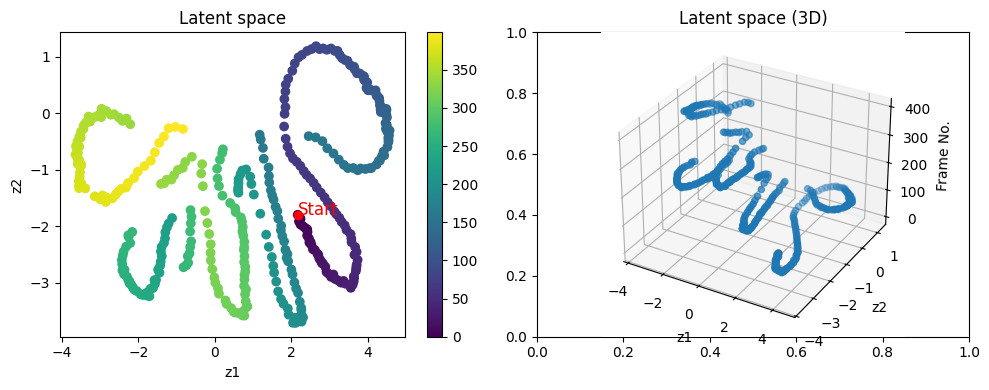

In [33]:
plotter.plot_latent_space()

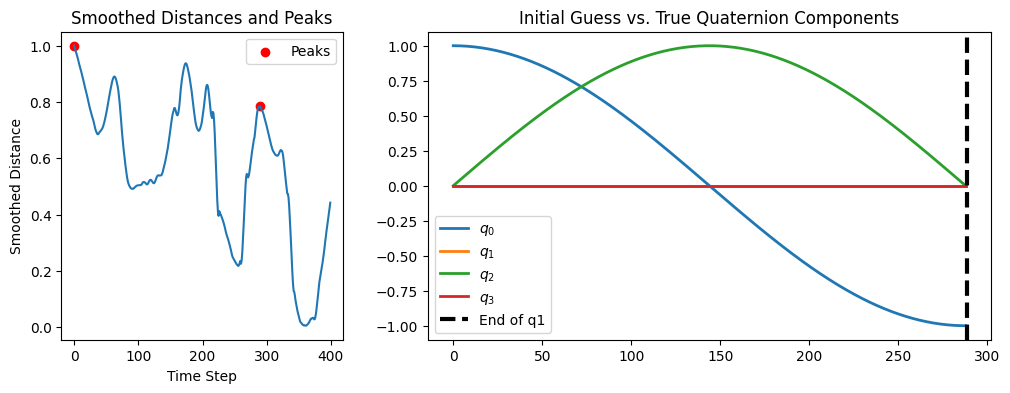

In [34]:
plotter.plot_smooth_dist_intial_guess()

To further validate the VAE, we compare reconstructed frames to the originals and observe a strong visual similarity.

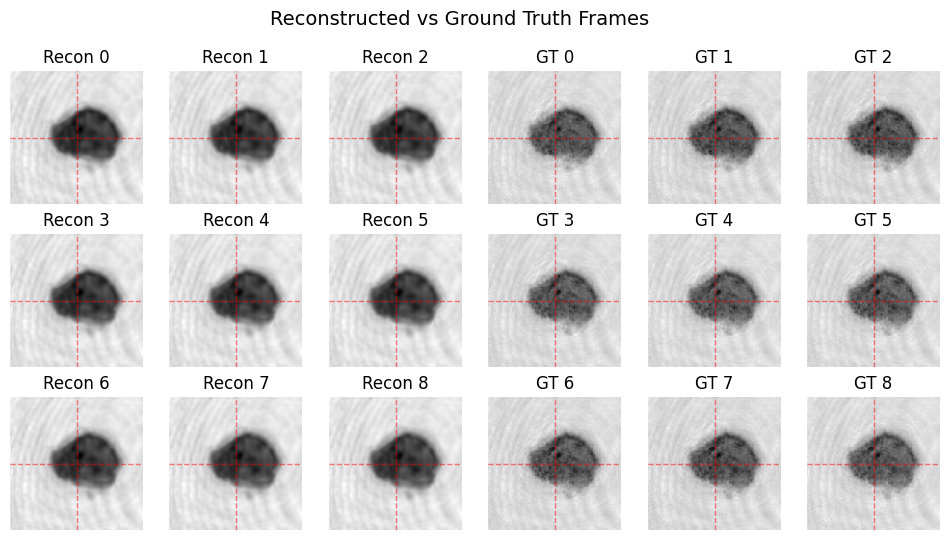

In [35]:
plotter.plot_reconstructed_vs_gt()

### 3.3 - Optimize the volume alone first

As outline in the main section, it is now time to proceede with the actual 3D-reconstruction optimization.

The optimization process flows more effectively when an initial 3D volume is optimized first. To achieve this, the volume is optimized for a few iterations before both the volume and rotation parameters are jointly optimized. While it is possible to provide a custom initial volume to begin the optimization, in this case, we start with a fixed volume value of 1.33.

In [ ]:
N = len(tomographic_model.frames) # Number of frames
idx = torch.arange(N) # Index of frames
epochs_object_only = 2 # Number of epochs for the object only optimization
batch_size_object_only = 128 # Batch size for the object only optimization

train the model for `epochs_object_only` epochs...

In [ ]:
# Toggle the gradients of the quaternion parameters to False
tomographic_model.toggle_gradients_quaternion(False)

# Move the model to device
tomographic_model.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=epochs_object_only, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomographic_model, DataLoader(idx, batch_size=batch_size_object_only , shuffle=True))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")


  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | vae_model     | VariationalAutoEncoder | 608 K  | train
1 | encoder       | Sequential             | 80.1 K | train
2 | fc_mu         | MultiLayerPerceptron   | 131 K  | train
3 | imaging_model | imaging_model          | 0      | train
4 | train_metrics | MetricCollection       | 0      | train
5 | val_metrics   | MetricCollection       | 0      | train
6 | test_metrics  | MetricCollection       | 0      | train
7 | optimizer     | Adam                   | 0      | train
  | other params  | n/a                    | 1.9 M  | n/a  
-----------------------------------------------------------------
2.1 M     Trainable params
609 K     Non-trainable params
2.7 M     Total params
10.828    Total estimated model params size (MB)
91        Modules in train mode
0         Modules in eval mode


Epoch 0:  10%|█         | 1/10 [15:24<2:18:40,  0.00it/s]

### 3.4 - Optimize the 3D volume and the rotation parameters

This is the main optimization loop, where both the 3D volume and rotation parameters are optimized simultaneously. It mirrors the earlier procedure, but now gradients for the rotation parameters are enabled.

In [ ]:
epochs_object_rot = 200 # Number of epochs for the object and rotation optimization
batch_size_object_rot = 128 # Batch size for the object and rotation optimization

and train the model for `epochs_object_rot` epochs...

In [ ]:
# Toggle the gradients of the quaternion parameters
tomographic_model.toggle_gradients_quaternion(True)

# Move the model to device
tomographic_model.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=epochs_object_rot, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomographic_model, DataLoader(idx, batch_size=batch_size_object_rot, shuffle=False))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")


  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | vae_model     | VariationalAutoEncoder | 608 K  | train
1 | encoder       | Sequential             | 80.1 K | train
2 | fc_mu         | MultiLayerPerceptron   | 131 K  | train
3 | imaging_model | imaging_model          | 0      | train
4 | train_metrics | MetricCollection       | 0      | train
5 | val_metrics   | MetricCollection       | 0      | train
6 | test_metrics  | MetricCollection       | 0      | train
7 | optimizer     | Adam                   | 0      | train
  | other params  | n/a                    | 1.9 M  | n/a  
-----------------------------------------------------------------
2.1 M     Trainable params
608 K     Non-trainable params
2.7 M     Total params
10.826    Total estimated model params size (MB)
91        Modules in train mode
0         Modules in eval mode
c:\Users\Fredrik\miniconda3\envs\deeplaydev\Lib\site-packages\lightning\py

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.35 GiB. GPU 0 has a total capacity of 24.00 GiB of which 0 bytes is free. Of the allocated memory 43.89 GiB is allocated by PyTorch, and 7.67 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 4.0 - Visualize the reconstructed volume and the parameters

Finally, we visualize the reconstructed 3D volume and the rotation parameters. The reconstructed volume is displayed as a 3D volume, while the rotation parameters are represented in a 3D scatter plot.

In [ ]:
# Move it to the GPU if possible for faster plotting
tomographic_model.move_all_to_device(DEV)

# Visualize the final volume and rotations.
plotter = tomodpdt.plotting.TomoPlotter(tomographic_model)

By visualizing summation views of the 3D object along the x, y, and z axes, we can assess how well the optimized volume matches the ground truth.

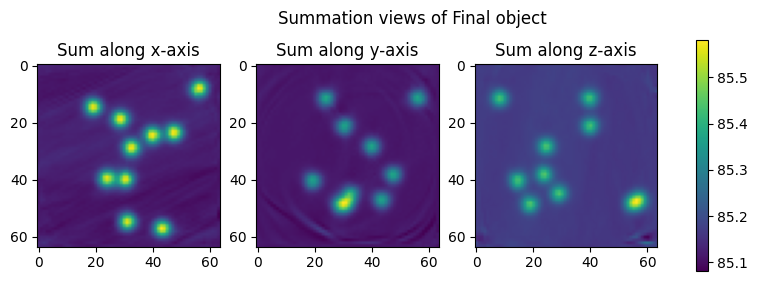

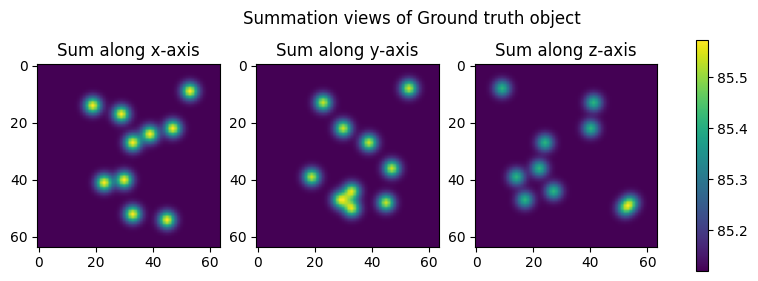

In [ ]:
plotter.plot_sum_object(save_name="Final object")

Instead of summation views, we can visualize the forward projections of the reconstructed object and compare them to the ground truth 2D frames. The similarity indicates a successful reconstruction.

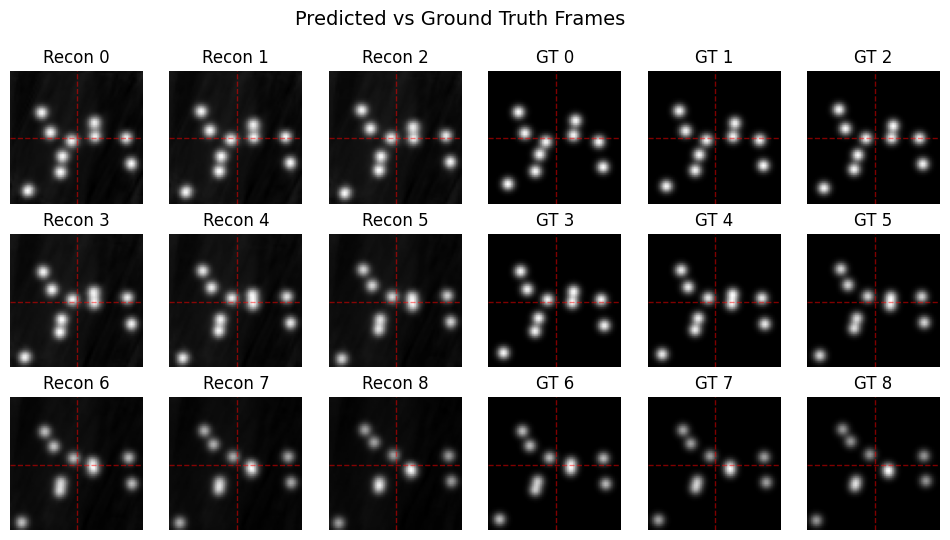

In [ ]:
plotter.plot_reconstructed_vs_gt(column_headers=["Predicted", "Ground Truth"], forward=True, save_name="Reconstructed vs GT")